# MFA: fungal berry microbiome / climate / chemisty / plot properties


In [1]:
import pandas as pd
import numpy as np
import os
import biom
import re

# Visualizations 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from adjustText import adjust_text

import prince

%matplotlib inline

In [2]:
#!mkdir /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/MFA/berries

In [3]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/MFA/berries'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/MFA/berries


In [4]:
%env TMPDIR=/scratch/lfloerl/tmpdata

env: TMPDIR=/scratch/lfloerl/tmpdata


In [6]:
group_colors = {
    #'Bacteria': "#440154FF",        # Dark purple  
    'Climate': "#3B528BFF",         # Deep blue (adjusted for distinction)  
    'Fungi': "#21908CFF",           # Greenish teal (more distinct from Climate)  
    'Management': "#5DC863FF",            # Bright green  
    'Plots': "#FDE725FF",           # Bright yellow (more distinct)  
    'Chemistry': "#482677FF"        # Darker purple to distinguish from Bacteria
}


# Load data

#### Microbiome

> ITS berries: try all berries (`berries_cOTUs_rarefied_labled.tsv`) as well as only harvest ones (`berries_harvest_cOTUs_rarefied_labled.tsv`)

In [7]:
df_ITS = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/berries-closedRefOTU/berries_harvest_cOTUs_rarefied_labled.tsv', sep='\t', index_col=0)
df_ITS.index.name = "SAMPLE_NAME"

In [8]:
df_ITS.shape

(316, 777)

#### Metadata

In [9]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_BerryChemistry.tsv', sep='\t')
chemistry_df = md_df[['SAMPLE_NAME',  'Tartrate_gL', 'Malate_gL','Glucose_gL', 'Fructose_gL']].set_index('SAMPLE_NAME')

chemistry_df

,Tartrate_gL,Malate_gL,Glucose_gL,Fructose_gL
SAMPLE_NAME,,,,
Lavaux_2021-08-31_must_Plot4,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot5,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot9,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot11,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot12,NaN,NaN,NaN,NaN
...,...,...,...,...
Lavaux_2023-09-20_must_Plot17_RepB,1.4960,0.0970,16.3860,18.247
Lavaux_2023-09-20_must_Plot17_RepC,1.2910,0.1040,18.6630,20.781
Lavaux_2023-09-20_must_Plot17_RepD,1.1200,0.0850,17.1530,18.839


In [14]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Management.tsv', sep='\t')
md_df = md_df[md_df['sample_type']=='must']

# Plot metadata
plot_df = md_df[['SAMPLE_NAME', 'Altitude', 'Average_slope', 'Exposition','Average_radiation', 'Grape_Yield_Estimate','Pruning_Weight']].set_index('SAMPLE_NAME')
categorical_cols = ['Exposition']
plot_df_dummies = pd.get_dummies(plot_df, columns=categorical_cols, drop_first=True)
# Convert boolean columns to integers (0 or 1)
boolean_columns = plot_df_dummies.select_dtypes(include='bool').columns
plot_df_dummies[boolean_columns] = plot_df_dummies[boolean_columns].astype(int)

# Map custom values for 'Grape Yield Est.' to ensure 'high' = 3, 'medium' = 2, 'low' = 1, and 'NaN' = 0
plot_df_dummies['Grape_Yield_Estimate'] = plot_df_dummies['Grape_Yield_Estimate'].map({'high': 3, 'medium': 2, 'low': 1}).fillna(0).astype(int)

sorted_columns = ['Altitude', 'Average_slope', 'Average_radiation', 'Exposition_South-West', 'Grape_Yield_Estimate', 'Pruning_Weight']
plot_df_dummies = plot_df_dummies[sorted_columns]

plot_df_dummies.tail()

,Altitude,Average_slope,Average_radiation,Exposition_South-West,Grape_Yield_Estimate,Pruning_Weight
SAMPLE_NAME,,,,,,
Lavaux_2023-09-20_must_Plot17_RepB,390,20,912.5,1,2,43.72
Lavaux_2023-09-20_must_Plot17_RepC,390,20,912.5,1,2,43.72
Lavaux_2023-09-20_must_Plot17_RepD,390,20,912.5,1,2,43.72
Lavaux_2023-09-20_must_Plot17_RepE,390,20,912.5,1,2,43.72
Lavaux_2021-09-30_must_Plot5_Row6/Vine30_ID37,400,30,912.5,1,2,57.41


In [15]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Climate.tsv', sep='\t')
md_df_soil = md_df[md_df['sample_type']=='must']

# Climate metadata
climate_df = md_df_soil[['SAMPLE_NAME', 'median_temperature', 'cv_temperature', 'median_rh', 'cv_rh' ]].set_index('SAMPLE_NAME')

climate_df.head()

,median_temperature,cv_temperature,median_rh,cv_rh
SAMPLE_NAME,,,,
Lavaux_2021-08-31_must_Plot4,18.650958,22.587667,72.792393,16.567322
Lavaux_2021-08-31_must_Plot5,19.047366,22.104867,70.192394,16.331714
Lavaux_2021-08-31_must_Plot9,18.256629,22.831881,73.077585,16.570451
Lavaux_2021-08-31_must_Plot11,18.541438,23.246939,72.501870,16.118351
Lavaux_2021-08-31_must_Plot12,18.244984,23.615955,72.934711,16.661423


In [16]:
# make a metadata df
df_metadata = md_df_soil[['SAMPLE_NAME', 'Year', 'Plot', 'COLLECTION_DATE']].set_index('SAMPLE_NAME')

### Merge for MFA

In [17]:
# Merge all dataframes on their index
df_merged = (
    climate_df
    .join(plot_df_dummies, how="inner")
    .join(chemistry_df, how="inner")
    .join(df_ITS, how="inner")
)

# Drop rows with any NA values
df_merged.dropna(inplace=True)

# Print the shape to check the final size
print(df_merged.shape)


(301, 791)


In [21]:
df_mfa = df_merged.copy()

# Keep track of the columns' origins
Fun_columns = df_ITS.columns.tolist()
plots_columns = ['Altitude', 'Average_slope', 'Exposition', 'Average_radiation']
management_columns = ['Grape_Yield_Estimate','Pruning_Weight']
climate_columns = climate_df.columns.tolist()
chemistry_columns = chemistry_df.columns.tolist()

multi_index_columns = (
    [('Climate', col) for col in climate_columns] +
    [('Plots', col) for col in plots_columns] +
    [('Management', col) for col in management_columns] +
    [('Chemistry', col) for col in chemistry_columns] + 
    [('Fungi', col) for col in Fun_columns])

# Subset data and assign multi-index
df_mfa.columns = pd.MultiIndex.from_tuples(multi_index_columns)  # Assign multi-index
df_mfa = df_mfa.astype("float64")

# Extract the group names (first level of multi-index)
groups = df_mfa.columns.levels[0].tolist()

df_mfa.shape

(301, 791)

In [22]:
# drop columns with zero variance 
zero_var_cols = df_mfa.std() == 0
df_mfa = df_mfa.loc[:, ~zero_var_cols]

df_mfa.shape

(301, 771)

In [23]:
# Check if there are any NaN values in df_mfa
nan_cells = df_mfa.isna().sum().sum()
print(f"Total NaN cells in df_mfa: {nan_cells}")

Total NaN cells in df_mfa: 0


# MFA 

## How many Components?

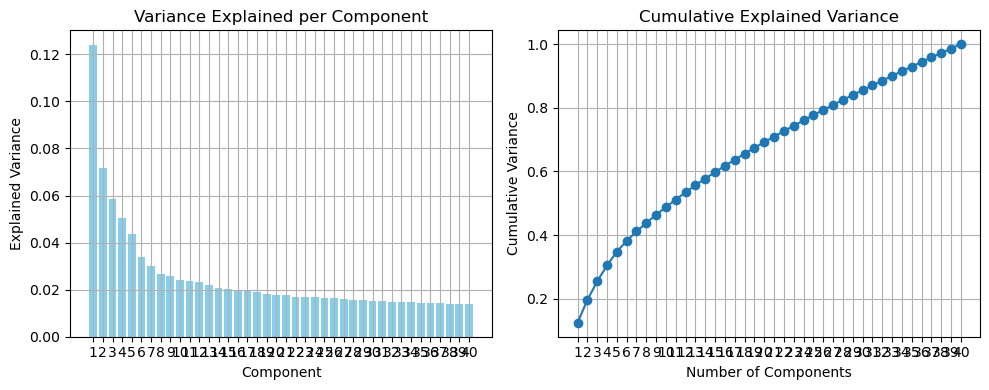

In [24]:
# Define the number of components to test
n_components = 40

# Define MFA and fit the model
mfa = prince.MFA(
    n_components=n_components,  
    n_iter=10, 
    copy=True,
    check_input=True,
    random_state=42)

# Fit MFA to the data (excluding metadata columns)
mfa = mfa.fit(
    df_mfa,
    groups=groups,
    supplementary_groups=None)

# Get explained variance per component
explained_variance_ratio = mfa.eigenvalues_ / np.sum(mfa.eigenvalues_)

# Create subplots for explained variance and cumulative variance plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bar plot for variance explained per component
axes[0].bar(range(1, n_components + 1), explained_variance_ratio[:n_components], color='skyblue')
axes[0].set_title('Variance Explained per Component')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Explained Variance')
axes[0].set_xticks(range(1, n_components + 1))
axes[0].grid(True)

# Line plot for cumulative explained variance (elbow plot)
axes[1].plot(range(1, n_components + 1), np.cumsum(explained_variance_ratio[:n_components]), marker='o', linestyle='-')
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance')
axes[1].set_xticks(range(1, n_components + 1))
axes[1].grid(True)

# Adjust layout to ensure proper display
plt.tight_layout()
plt.show()

In [25]:
mfa.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,2.612,5.21%,5.21%
1,1.506,3.00%,8.21%
2,1.232,2.46%,10.66%
3,1.059,2.11%,12.78%
4,0.915,1.82%,14.60%
5,0.711,1.42%,16.02%
6,0.630,1.26%,17.27%
7,0.561,1.12%,18.39%
8,0.547,1.09%,19.48%


In [26]:
# Initialize MFA model
mfa = prince.MFA(
    n_components=10,  
    n_iter=10, 
    copy=True,
    check_input=True,
    random_state=42)

# Fit MFA to the data (excluding metadata columns)
mfa = mfa.fit(
    df_mfa,
    groups=groups,
    supplementary_groups=None)

mfa_results = mfa.transform(df_mfa)
# Merge MFA results with metadata to retain 'year' information
mfa_results = mfa_results.merge(df_metadata, left_index=True, right_index=True)

mfa.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,2.612,5.21%,5.21%
1,1.506,3.00%,8.21%
2,1.232,2.46%,10.66%
3,1.059,2.11%,12.78%
4,0.915,1.82%,14.60%
5,0.711,1.42%,16.02%
6,0.630,1.26%,17.27%
7,0.561,1.12%,18.39%
8,0.547,1.09%,19.48%


/scratch/lfloerl/tmpdata/ipykernel_220914/921167405.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y='Sum of Contributions', data=df_plot, palette=group_colors)


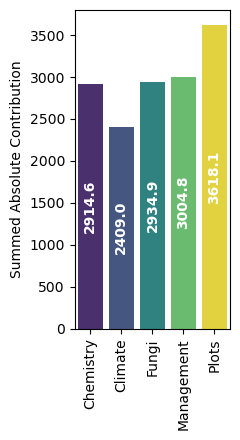

In [38]:
partial_coords = mfa.partial_row_coordinates(df_mfa)

# Assuming `partial_coords` is the dataframe you obtained from MFA
df_abs_sum = partial_coords.abs().sum()

# Convert to DataFrame for plotting
df_plot = df_abs_sum.groupby(level=0).sum().reset_index()
df_plot.columns = ['Group', 'Sum of Contributions']

# Plot
plt.figure(figsize=(2.5,4.5))
ax = sns.barplot(x='Group', y='Sum of Contributions', data=df_plot, palette=group_colors)
# Add numeric values on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', 
                (p.get_x() + p.get_width() / 2, p.get_height() * 0.5),  # Position inside the bar
                ha='center', va='center', fontsize=10, fontweight='bold', 
                color='white', rotation=90)

plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Summed Absolute Contribution')
plt.tight_layout()
plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/MFA_Berries_Contributions.png', dpi=1000)
plt.show()

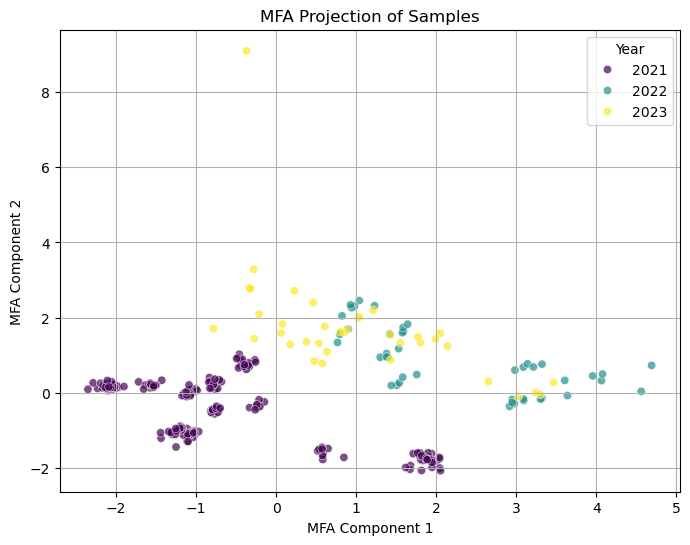

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], hue="Year", palette="viridis", alpha=0.7)
plt.xlabel("MFA Component 1")
plt.ylabel("MFA Component 2")
plt.title("MFA Projection of Samples")
plt.grid()
plt.show()

In [29]:
# Extract coordinates of individuals (first 2 components)
individuals = mfa_results.iloc[:, :2].values  

# Extract variable loadings (first 2 components) and drop multi-index properly
variable_loadings_df = mfa.column_correlations.iloc[:, :2].copy().reset_index()

# Ensure correct column names
variable_loadings_df.columns = ["Variable", "MFA Comp 1", "MFA Comp 2"]

# Compute Loadings Contribution (sum of absolute correlations)
variable_loadings_df["Loadings Contribution"] = variable_loadings_df[["MFA Comp 1", "MFA Comp 2"]].abs().sum(axis=1)

# Handle infinite values: replace with max Loadings Contribution + 0.1
max_load = variable_loadings_df.loc[np.isfinite(variable_loadings_df["Loadings Contribution"]), "Loadings Contribution"].max()
variable_loadings_df["Loadings Contribution"] = variable_loadings_df["Loadings Contribution"].replace([np.inf, -np.inf], max_load + 0.1)

# Sort by Loadings Contribution
variable_loadings_df = variable_loadings_df.sort_values(by="Loadings Contribution", ascending=False)

# Extract first character of "Variable" as "group"
variable_loadings_df["group"] = variable_loadings_df["Variable"].apply(lambda x: x[0])

# Select top 10 based on Loadings Contribution
top_loadings = variable_loadings_df.nlargest(10, "Loadings Contribution").copy()

# Extract variable names from tuples more robustly
top_loadings["Variable"] = top_loadings["Variable"].astype(str).str.extract(r",\s*([^,)]*)\)?$")[0]

tl_list = top_loadings['Variable'].to_list()

In [30]:
tl_list

["'median_rh'",
 "'Malate_gL'",
 "'cv_temperature'",
 "'Glucose_gL'",
 "'Grape_Yield_Estimate'",
 "'Fructose_gL'",
 "'median_temperature'",
 "'Pruning_Weight'",
 "'cv_rh'",
 "'Altitude'"]

In [ ]:
# Function to extract the family name
def extract_family(variable):
    match = re.search(r"f__([^;]+)", variable)
    return match.group(1) if match else variable  # Return the family name if found, else keep the original value

# Apply function only to rows where 'Variable' starts with 'Bacteria_' or 'Fungi_'
mask = top_loadings['Variable'].str.startswith(("'d__Bacteria", "'k__Fungi"))
top_loadings.loc[mask, 'Variable'] = top_loadings.loc[mask, 'Variable'].apply(extract_family)


top_loadings

,Variable,MFA Comp 1,MFA Comp 2,Loadings Contribution,group
6,'median_rh',-0.667711,-0.554848,1.222559,Climate
1,'Malate_gL',-0.603014,-0.583999,1.187012,Chemistry
5,'cv_temperature',0.648217,0.477061,1.125278,Climate
2,'Glucose_gL',-0.732084,0.366478,1.098562,Chemistry
765,'Grape_Yield_Estimate',0.603163,-0.475873,1.079037,Management
3,'Fructose_gL',-0.724035,0.353681,1.077716,Chemistry
4,'median_temperature',0.297311,0.721310,1.018621,Climate
766,'Pruning_Weight',-0.779732,-0.165672,0.945405,Management
7,'cv_rh',0.697521,0.246158,0.943679,Climate
767,'Altitude',0.583117,-0.331464,0.914581,Plots


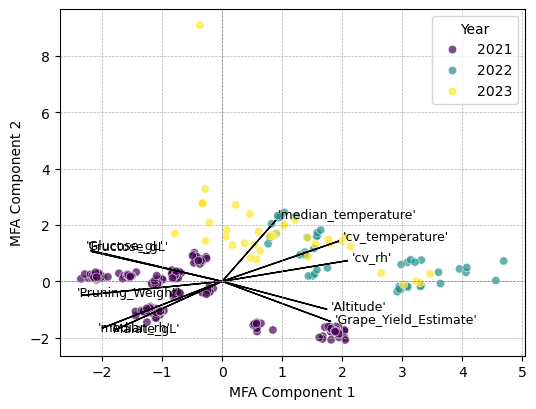

In [32]:
# Biplot
fig, ax = plt.subplots(figsize=(6, 4.5))

# Scatter plot of individuals, colored by year
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], hue="Year", palette="viridis", alpha=0.7)


# Define a scaling factor to extend the arrows
scaling_factor = 3 # Adjust this value to control arrow length
# Plot the top loadings as arrows
for i, row in top_loadings.iterrows():
    ax.arrow(0, 0, row["MFA Comp 1"] * scaling_factor, row["MFA Comp 2"] * scaling_factor, 
             head_width=0.02, head_length=0.02, color="black", length_includes_head=True)
    
    ax.text(row["MFA Comp 1"] * (scaling_factor + 0.1),  # Adjust text position accordingly
            row["MFA Comp 2"] * (scaling_factor + 0.1), 
            row["Variable"], fontsize=9)


# Formatting
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.set_xlabel("MFA Component 1")
ax.set_ylabel("MFA Component 2")
#ax.set_title("MFA Biplot (Samples Colored by Year)")
ax.grid(True, linestyle="--", linewidth=0.5)
ax.legend(title="Year", bbox_to_anchor=(1, 1))

plt.show()

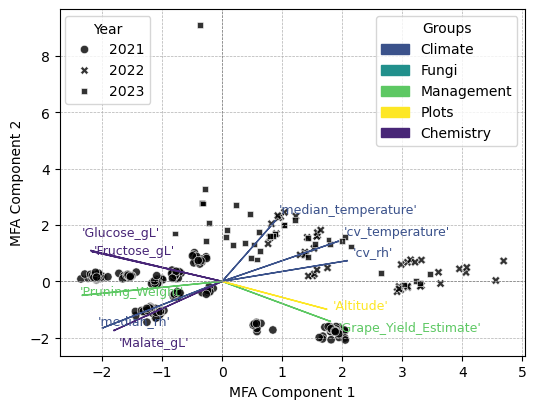

In [37]:
# Biplot
fig, ax = plt.subplots(figsize=(6,4.5))

# Scatter plot of individuals, colored by year
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], style="Year", alpha=0.8, color='black')

# Define a scaling factor to extend the arrows
scaling_factor = 3  

# Create a color map based on the group and intensity (Total Contribution)
norm = plt.Normalize(vmin=top_loadings['Loadings Contribution'].min(), vmax=top_loadings['Loadings Contribution'].max())  
sm = plt.cm.ScalarMappable(cmap='Greys', norm=norm)
sm.set_array([])

## Store text objects for later adjustment
text_objects = []

for i, row in top_loadings.iterrows():
    group_color = group_colors.get(row['group'], 'black')  
    ax.arrow(0, 0, row["MFA Comp 1"] * scaling_factor, row["MFA Comp 2"] * scaling_factor, 
             head_width=0.02, head_length=0.02, color=group_color, length_includes_head=True)
    
    # Add text label with matching color
    text = ax.text(row["MFA Comp 1"] * (scaling_factor + 0.1),  
                   row["MFA Comp 2"] * (scaling_factor + 0.1), 
                   row["Variable"], fontsize=9, color=group_color)
    text_objects.append(text)

# Adjust label positions to prevent overlap
adjust_text(text_objects, ax=ax, expand_points=(1.4, 1.4), arrowprops=dict(arrowstyle="-", color='gray', lw=0))

# Add first legend for groups (custom patches)
group_legend_patches = [matplotlib.patches.Patch(color=color, label=group) for group, color in group_colors.items()]
group_legend = ax.legend(handles=group_legend_patches, title="Groups", loc="upper right", bbox_to_anchor=(0.999, 1))

# Add second legend for Year (from scatterplot)
year_legend = ax.legend(title="Year", bbox_to_anchor=(0.21, 1))

# Add both legends back to the plot
ax.add_artist(group_legend)

# Formatting
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.set_xlabel("MFA Component 1")
ax.set_ylabel("MFA Component 2")
ax.set_title("")

# Show grid
ax.grid(True, linestyle="--", linewidth=0.5)

plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/MFA_Berries.png', dpi=1000)

plt.show()
